# Utilities

In [1]:
data_dir = '../data/'
model_dir = '../models/'
results_dir = '../results/'

In [2]:
truncate = True
num_timepoints = 500

if truncate == False:
    num_timepoints = 3000

In [3]:
import numpy as np
from numba import jit
@jit(nopython=True)
def _numba_peak_detection_single(waveform, d2, T1, T2):
    """Numba-compiled inner loop for single waveform processing."""
    n = len(waveform)
    peaks = []
    Int = np.zeros(n)
    
    for i in range(1, n):
        if waveform[i-1] < T1:
            continue
            
        if d2[i] > 0:
            Int[i] = Int[i-1] + d2[i]
        elif Int[i-1] > T2:
            peaks.append(i-1)
            Int[i] = 0.0
        else:
            Int[i] = 0.0

    return peaks


def numba_batched_derivative_peak_detection(waveforms, T1, T2):
    """
    Numba-accelerated derivative-based peak detection for multiple waveforms.
    
    Args:
    waveforms (np.array): 2D array where each row is a waveform (shape: [n_waveforms, n_points])
    T1 (float): Threshold for initial amplitude check.
    T2 (float): Threshold for integrated second derivative.
    
    Returns:
    list: List of detected peak indices for each waveform.
    """
    if len(waveforms.shape) == 1:
        waveforms = waveforms.reshape(1, -1)
    
    n_waveforms, n_points = waveforms.shape
    
    # Vectorized computation of derivatives
    D1 = np.zeros_like(waveforms)
    D1[:,1:] = np.maximum(np.diff(waveforms, axis=1), 0)
    mask = waveforms[:,:-1] < T1
    D1[:,1:][mask] = 0

    D2 = np.zeros_like(waveforms)
    D2[:,1:] = np.maximum(np.diff(D1, axis=1), 0)
    
    # Process each waveform using Numba
    all_peaks = []
    for w_idx in range(n_waveforms):
        peaks = _numba_peak_detection_single(waveforms[w_idx], D2[w_idx], T1, T2)
        all_peaks.append(list(peaks))  # Convert from numba list to Python list
    
    return all_peaks

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}


# How to use the D2 Algorithm function:
# Set your thresholds (these need to be tuned based on the specific data)
# T1 = 3 * np.std(data['wf_i'][1][2500:2900])  # Example: 3 times the std of the noise baseline
# T2 = 0.053320  # This needs to be tuned based on your data

# detected_peaks = process_waveforms(waveforms, T1, T2)

def derivative_peak_detection(waveform, T1, T2):
    """
    Derivative-based peak detection algorithm.
    
    Args:
    waveform (np.array): Input waveform with n points.
    T1 (float): Threshold for initial amplitude check.
    T2 (float): Threshold for integrated second derivative.
    
    Returns:
    list: Indices of detected peaks.
    """
    n = len(waveform)
    Output = []
    D1 = np.zeros(n)
    D2 = np.zeros(n)
    Int = np.zeros(n)
    
    for i in range(1, n):
        if waveform[i-1] < T1:
            continue
        
        D1[i] = max(waveform[i] - waveform[i-1], 0)
        D2[i] = max(D1[i] - D1[i-1], 0)
        
        if D2[i] > 0:
            Int[i] = Int[i-1] + D2[i]
        elif Int[i-1] > T2:
            Output.append(i-1)
            Int[i] = 0  # Reset integration after detecting a peak
        else:
            Int[i] = 0  # Reset integration if no peak detected

    return Output


def process_waveforms(waveforms, T1, T2):
    """
    Process multiple waveforms using the derivative algorithm.

    Returns:
        list: List of detected peak indices for each waveform.
    """
    all_peaks = []
    for waveform in tqdm(waveforms, desc="Processing waveforms", unit="waveform"):
        peaks = derivative_peak_detection(waveform, T1, T2)
        all_peaks.append(peaks)
    return all_peaks

def d1_peak_detection(waveform, t1, t2):
    """
    D1 algorithm for real-time peak detection.
    
    Args:
        waveform (np.array): Input waveform with n points.
        t1 (float): Threshold for short-term gradient V(i+1) - V(i).
        t2 (float): Threshold for medium-term gradient V(i+2) - V(i).
    
    Returns:
        int: Number of detected peaks.
    """
    n = len(waveform)
    
    peak_count = 0
    in_peak = False
    
    # Process each point in real-time fashion
    for i in range(n - 2):  # We need i+2 to be valid
        # Calculate gradients
        short_gradient = waveform[i + 1] - waveform[i]
        medium_gradient = waveform[i + 2] - waveform[i]
        
        # Determine signal (1 or 0)
        signal = 1 if (short_gradient > t1 or medium_gradient > t2) else 0
        
        # Peak detection logic
        if signal == 1 and not in_peak:
            # Start of a new peak
            in_peak = True
        elif signal == 0 and in_peak:
            # End of current peak
            in_peak = False
            peak_count += 1
    
    # Handle case where waveform ends while in a peak
    if in_peak:
        peak_count += 1
    
    return peak_count

def process_waveforms_d1(waveforms, t1, t2):
    """
    Process multiple waveforms using the D1 algorithm.
    
    Args:
        waveforms: Array of waveforms to process.
        t1 (float): Threshold for short-term gradient.
        t2 (float): Threshold for medium-term gradient.
    
    Returns:
        list: List of detected peak counts for each waveform.
    """
    peak_counts = []
    # for waveform in tqdm(waveforms, desc="Processing waveforms with D1", unit="waveform"):
    for waveform in waveforms:
        count = d1_peak_detection(waveform, t1, t2)
        peak_counts.append(count)
    return peak_counts

# Extract true peaks from labels

def extract_true_peaks_from_labels(testdata):
    """
    Extract true peak positions from labels where tag_values = 1 or 2.
    
    Returns:
        list: List of true peak time values for each waveform.
    """
    tag_values = testdata['tag_values']
    tag_times = testdata['tag_times']
    
    all_true_peaks = []
    
    print("Extracting true peaks from labels (vectorized)...")
    
    for i in tqdm(range(len(tag_values)), desc="Processing waveforms", unit="waveform"):
        # Create mask for tags 1 and 2
        peak_mask = (tag_values[i] == 1) | (tag_values[i] == 2)
        # Extract corresponding times
        true_peak_times = tag_times[i][peak_mask].tolist()
        
        all_true_peaks.append(true_peak_times)
    
    return all_true_peaks

def extract_true_primary_peaks_from_labels(testdata):
    """
    Extract true primary peak positions from labels where tag_values = 1.
    
    Returns:
        list: List of true primary peak time values for each waveform.
    """
    tag_values = testdata['tag_values']
    tag_times = testdata['tag_times']
    
    all_true_peaks = []
    
    print("Extracting true primary peaks from labels (vectorized)...")
    
    for i in tqdm(range(len(tag_values)), desc="Processing waveforms", unit="waveform"):
        # Create mask for tags 1
        peak_mask = (tag_values[i] == 1)
        # Extract corresponding times
        true_peak_times = tag_times[i][peak_mask].tolist()
        
        all_true_peaks.append(true_peak_times)
    
    return all_true_peaks

# Fixed Clusterization Method

def estimate_primary_from_cluster_window(detected_peaks, b, c, d):
    """
    Estimate the number of primary ionizations per waveform by merging nearby peaks in a sliding window.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b (int): Number of units to look forward in time window.
        c (float): Normalization factor (divides peak count in window).
        d (float): Maximum number of peaks in window.
    Returns:
        list: Estimated number of primary ionizations (float) for each waveform.
    """
    estimated_counts = []

    for peaks in detected_peaks:

        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        count = 0.0

        while remaining_peaks:
            current = remaining_peaks[0]
            window_start = current
            window_end = current + b

            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                count += 1
            elif d*c > len(cluster) > c:
                count += len(cluster) / c
            else:
                count += d

            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        estimated_counts.append(count)
    return estimated_counts

def collect_cluster_peaks(detected_peaks, b, c, d):
    """
    For each waveform, return a list of peak lists used in each cluster count step.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b (int): Window size to look forward.
        c (float): Normalization factor.
        d (float): Maximum number of peaks allowed in window.
    
    Returns:
        list of lists: Each inner list contains the peak values used at each cluster step.
    """
    all_cluster_peaks = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        waveform_clusters = []

        while remaining_peaks:
            current = remaining_peaks[0]
            window_start = current

            window_end = current + b

            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            # Determine how many peaks to take from this cluster
            if len(cluster) <= c:
                n = 1
            elif d * c > len(cluster) > c:
                n = int(len(cluster) / c)
            else:
                n = int(d)

            # Store the first n peaks in this cluster (or fewer if not enough)
            waveform_clusters.append(cluster[:n])
            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        all_cluster_peaks.append(waveform_clusters)

    return all_cluster_peaks

def find_best_indices_3d(data, mode="mean"):
    if mode == "mean":
        idx = np.unravel_index(np.argmin(np.abs(data)), data.shape)
    elif mode == "std":
        idx = np.unravel_index(np.argmin(data), data.shape)
    return idx

def plot_heatmap_2d_slice(data_3d, d_idx, title, x_labels, y_labels, x_name, y_name, cmap='viridis', highlight=None):
    data = data_3d[:, :, d_idx]
    plt.figure(figsize=(10, 6))
    im = plt.imshow(data, origin='lower', cmap=cmap,
                    extent=[x_labels[0], x_labels[-1], y_labels[0], y_labels[-1]],
                    aspect='auto')

    cbar = plt.colorbar(im, format="%.4f")
    cbar.ax.tick_params(labelsize=10)

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(f"{title} (d = {d_values[d_idx]})")

    if highlight:
        i, j, _ = highlight
        x_val = x_labels[j]
        y_val = y_labels[i]
        plt.plot(x_val, y_val, 'ro', markersize=8, label='Best Point')
        plt.legend()

    plt.tight_layout()
    plt.show()


# Adaptive Clusterization Method

import itertools

if truncate:
        region_bounds = {
        'r1': (0, 130),
        'r2': (130, 400),
        'r3': (400, 500)
    }

else:
    region_bounds = {
        'r1': (0, 130),
        'r2': (130, 400),
        'r3': (400, 1550),
        'r4': (1550, 3000),
    }

# region_bounds = {
    #     'r1': (0, 130),
    #     'r2': (130, 1600),
    #     'r3': (1600, 3000),
    # }

def estimate_primary_from_cluster_window_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Adaptive estimation of primary ionizations per waveform using different parameters for different time regions.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Keys are region names ('r1', 'r2', ...), values are parameter values.
    
    Returns:
        list: Estimated primary ionizations per waveform.
    """
    estimated_counts = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        count = 0.0

        while remaining_peaks:
            current = remaining_peaks[0]

            # Determine region
            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                count += 1
            elif d * c > len(cluster) > c:
                count += len(cluster) / c
            else:
                count += d

            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        estimated_counts.append(count)
    return estimated_counts


def collect_cluster_peaks_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Collect cluster peaks per waveform with region-adapted parameters.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Region-specific parameter mappings.

    Returns:
        list of lists: Each inner list contains peak lists used in each cluster.
    """
    all_cluster_peaks = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        waveform_clusters = []

        while remaining_peaks:
            current = remaining_peaks[0]

            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                n = 1
            elif d * c > len(cluster) > c:
                n = int(len(cluster) / c)
            else:
                n = int(d)

            waveform_clusters.append(cluster[:n])
            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        all_cluster_peaks.append(waveform_clusters)

    return all_cluster_peaks

def scan_adaptive_parameters_region_wise(detected_peaks, true_primary_peaks):
    """
    Scan optimal parameters for each region using true primary peaks.
    
    Args:
        detected_peaks (list): List of detected peak positions for each waveform
        true_primary_peaks (list): List of true primary peak positions for each waveform (from extract_true_primary_peaks_from_labels)
    """

    b_values = np.arange(1, 100, 1)
    c_values = np.arange(0.8, 2.0, 0.1)
    d_values = np.arange(1, 6, 1)
    
    best_params = {}
    region_results = {}
    
    for region, (low, high) in region_bounds.items():
        print(f"Scanning parameters for region {region} ({low}-{high})")
        
        region_detected_peaks = []
        region_true_counts = []
        
        for i, peaks in enumerate(detected_peaks):
            region_peaks = [p for p in peaks if low <= p < high]
            true_peaks_in_region = [p for p in true_primary_peaks[i] if low <= p < high]
            true_count_in_region = len(true_peaks_in_region)
            if region_peaks:
                region_detected_peaks.append(region_peaks)
                region_true_counts.append(true_count_in_region)
        
        if not region_detected_peaks:
            best_params[region] = {'b': 10, 'c': 1.0, 'd': 2}
            region_results[region] = float('inf')
            print(f"No detected peaks in region {region}, using default parameters")
            continue
        
        region_true_counts = np.array(region_true_counts)
        
        best_score = float('inf')
        best_region_params = None
        
        for b, c, d in tqdm(list(itertools.product(b_values, c_values, d_values)), 
                           desc=f"Region {region}"):
            
            temp_b_map = {r: 10 for r in region_bounds.keys()}
            temp_c_map = {r: 1.0 for r in region_bounds.keys()}
            temp_d_map = {r: 2 for r in region_bounds.keys()}
            
            temp_b_map[region] = int(b)
            temp_c_map[region] = float(c)
            temp_d_map[region] = int(d)
            
            estimated_counts = []
            for peaks in region_detected_peaks:
                count = estimate_single_region_count(peaks, b, c, d)
                estimated_counts.append(count)
            
            estimated_counts = np.array(estimated_counts)
            
            # Calculate relative errors: (estimated - true) / true
            with np.errstate(divide='ignore', invalid='ignore'):
                relative_errors = (estimated_counts - region_true_counts) / region_true_counts
                # Handle division by zero and invalid values
                relative_errors = relative_errors[np.isfinite(relative_errors)]
            
            # Calculate score based on relative errors
            if len(relative_errors) > 0:
                score = np.abs(np.mean(relative_errors))  # Mean squared relative error
            else:
                score = float('inf')  # If no valid relative errors, set high score
            
            if score < best_score:
                best_score = score
                best_region_params = {'b': b, 'c': c, 'd': d}
                # print(f"Best score: {score:.4f}")
                # print(f"Best params: {best_region_params}")
        
        best_params[region] = best_region_params
        region_results[region] = best_score
        print(f"Best params for {region}: {best_region_params}, Score: {best_score:.4f}")
    
    return best_params, region_results

def estimate_single_region_count(peaks, b, c, d):
    if not peaks:
        return 0.0
    
    peaks = sorted(peaks)
    remaining_peaks = peaks.copy()
    count = 0.0
    
    while remaining_peaks:
        current = remaining_peaks[0]
        window_start = current
        window_end = current + b
        
        cluster = [p for p in remaining_peaks if window_start <= p <= window_end]
        
        if len(cluster) <= c:
            count += 1
        elif d * c > len(cluster) > c:
            count += len(cluster) / c
        else:
            count += d
        
        remaining_peaks = [p for p in remaining_peaks if p not in cluster]
    
    return count

def run_adaptive_parameter_optimization(detected_peak, true_primary_peaks):
    """Complete adaptive parameter optimization workflow"""
    
    print("Starting adaptive parameter scanning...")
    
    # Step 1: Parameter scanning
    best_params, region_results = scan_adaptive_parameters_region_wise(
        detected_peak, 
        true_primary_peaks
    )
    
    # Step 2: Format conversion
    b_map = {region: params['b'] for region, params in best_params.items()}
    c_map = {region: params['c'] for region, params in best_params.items()}
    d_map = {region: params['d'] for region, params in best_params.items()}
    
    # Step 3: Final prediction
    adaptive_estimates = estimate_primary_from_cluster_window_adaptive(
        detected_peak, b_map, c_map, d_map
    )
    
    # Step 4: Compare with fixed parameter method
    # Use default fixed parameters
    fixed_estimates = estimate_primary_from_cluster_window(
        detected_peak, b=24, c=1.60, d=2
    )
    # fixed_estimates = estimate_primary_from_cluster_window(
    #     detected_peak, b=69, c=0.899, d=3
    # )

    true_primary_peak_counts = [len(peaks) for peaks in true_primary_peaks]
    true_primary_peak_counts = np.array(true_primary_peak_counts)
    adaptive_estimates = np.array(adaptive_estimates)
    fixed_estimates = np.array(fixed_estimates)
    
    
    # Step 5: Performance comparison
    adaptive_mae = np.mean(np.abs(adaptive_estimates - true_primary_peak_counts))
    fixed_mae = np.mean(np.abs(fixed_estimates - true_primary_peak_counts))
    
    print(f"\nPerformance comparison:")
    print(f"Adaptive method MAE: {adaptive_mae:.4f}")
    print(f"Fixed parameter method MAE: {fixed_mae:.4f}")
    print(f"Improvement: {((fixed_mae - adaptive_mae) / fixed_mae * 100):.2f}%")
    
    # Step 6: Visualization
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Parameter distribution
    plt.subplot(2, 2, 1)
    regions = list(best_params.keys())
    b_values = [best_params[r]['b'] for r in regions]
    plt.bar(regions, b_values)
    plt.title('Optimal b parameters by region')
    plt.ylabel('b value')
    
    plt.subplot(2, 2, 2)
    c_values = [best_params[r]['c'] for r in regions]
    plt.bar(regions, c_values)
    plt.title('Optimal c parameters by region')
    plt.ylabel('c value')
    
    # Subplot 3: Prediction comparison
    plt.subplot(2, 2, 3)
    adaptive_corr = np.corrcoef(true_primary_peak_counts, adaptive_estimates)[0, 1]
    fixed_corr = np.corrcoef(true_primary_peak_counts, fixed_estimates)[0, 1]

    plt.scatter(true_primary_peak_counts, adaptive_estimates, alpha=0.6, label=f'Adaptive (R={adaptive_corr:.3f})')
    plt.scatter(true_primary_peak_counts, fixed_estimates, alpha=0.6, label=f'Fixed (R={fixed_corr:.3f})')
    plt.plot([0, max(true_primary_peak_counts)], [0, max(true_primary_peak_counts)], 'r--')
    plt.xlabel('True Counts')
    plt.ylabel('Estimated Counts')
    plt.legend()
    plt.title('Prediction accuracy comparison')
    
    # Subplot 4: Error distribution
    plt.subplot(2, 2, 4)
    with np.errstate(divide='ignore', invalid='ignore'):
        adaptive_rel_errors = (np.array(adaptive_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        fixed_rel_errors = (np.array(fixed_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        adaptive_rel_errors = adaptive_rel_errors[np.isfinite(adaptive_rel_errors)]
        fixed_rel_errors = fixed_rel_errors[np.isfinite(fixed_rel_errors)]

    # Calculate mean and std for relative errors
    adaptive_rel_mean = np.mean(adaptive_rel_errors)
    adaptive_rel_std = np.std(adaptive_rel_errors)
    fixed_rel_mean = np.mean(fixed_rel_errors)
    fixed_rel_std = np.std(fixed_rel_errors)

    plt.hist(adaptive_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Adaptive (μ={adaptive_rel_mean:.3f}, σ={adaptive_rel_std:.3f})', density=False)
    plt.hist(fixed_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Fixed (μ={fixed_rel_mean:.3f}, σ={fixed_rel_std:.3f})', density=False)
    plt.xlabel('Relative Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Relative error distribution comparison')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'best_params': best_params,
        'b_map': b_map,
        'c_map': c_map,
        'd_map': d_map,
        'adaptive_estimates': adaptive_estimates,
        'region_results': region_results
    }

def process_momentum_subsets_FCA(particle_subsets, particle_name, T1, T2, max_events=5000):

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())

    # set best parameters
    if (particle_subsets[5.0]['wf_i'].shape[1] == 3000):
        best_b = 24
        best_c = 1.6
        best_d = 2

    if (particle_subsets[5.0]['wf_i'].shape[1] == 500):
        # best_b = 43
        # best_c = 0.8
        # best_d = 3

        # best_b = 52
        # best_c = 1.1
        # best_d = 3

        # best_b = 8
        # best_c = 2.8999999999999995
        # best_d = 2

        best_b = 68
        best_c = 0.7999999999999999
        best_d = 3

    else:
        raise ValueError("best params haven't been selected")
    

    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = numba_batched_derivative_peak_detection(wf_subset, T1, T2)
        primary_counts = estimate_primary_from_cluster_window(detected_peaks, b=best_b, c=best_c, d=best_d)
        primary_counts = np.array(primary_counts) * 0.93
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts)
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_D1(particle_subsets, particle_name, T1, T2, max_events=5000):

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = process_waveforms_d1(wf_subset, T1, T2)
        primary_counts = np.array(detected_peaks) * 0.93

        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts) 
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_D2(particle_subsets, particle_name, T1, T2, max_events=5000):

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = process_waveforms(wf_subset, T1, T2)
        primary_counts = np.array([len(peaks) for peaks in detected_peaks]) * 0.93
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts) 
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_ACA(particle_subsets, particle_name, T1, T2, max_events=5000):

    region_bounds = {
        'r1': (0, 125),
        'r2': (125, 400),
        'r3': (400, 500)
    }
    
    # if (particle_subsets[5.0]['wf_i'].shape[1] == 3000):
    #     best_params = {
    #         # 'r1': {'b': 8, 'c': 0.8, 'd': 2},
    #         # 'r2': {'b': 32, 'c': 1.0, 'd': 5},
    #         # 'r3': {'b': 67, 'c': 1.4, 'd': 2},
    #         # 'r4': {'b': 99, 'c': 0.8, 'd': 1}
    #     }

    if (particle_subsets[5.0]['wf_i'].shape[1] == 500):
        # best_params = {
        # 'r1': {'b': 3, 'c': 0.9, 'd': 2},
        # 'r2': {'b': 26, 'c': 0.9, 'd': 5},
        # 'r3': {'b': 25, 'c': 1.6999999999999997, 'd': 4},
        # 'r4': {'b': 43, 'c': 1.6999999999999997, 'd': 2}
        # }

        # best_params = {
        #     'r1': {'b': 10, 'c': 0.9, 'd': 2},
        #     'r2': {'b': 53, 'c': 0.9, 'd': 4},
        #     'r3': {'b': 65, 'c': 1.7999999999999998, 'd': 2},
        #     'r4': {'b': 98, 'c': 1.8999999999999997, 'd': 2}
        # }
        
    #     best_params = {
    #     'r1': {'b': 4, 'c': 0.9, 'd': 2},
    #     'r2': {'b': 24, 'c': 1.2999999999999998, 'd': 3},
    #     'r3': {'b': 91, 'c': 1.7999999999999998, 'd': 2},
    # }

        best_params = {
        'r1': {'b': 4, 'c': 0.9, 'd': 2},
        'r2': {'b': 30, 'c': 1.2999999999999998, 'd': 5},
        'r3': {'b': 91, 'c': 1.7999999999999998, 'd': 2}
    }

    else:
        raise ValueError("best params haven't been selected")
    
    print(region_bounds)

    b_map = {region: params['b'] for region, params in best_params.items()}
    c_map = {region: params['c'] for region, params in best_params.items()}
    d_map = {region: params['d'] for region, params in best_params.items()}


    
    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = numba_batched_derivative_peak_detection(wf_subset, T1, T2)
        primary_counts = estimate_primary_from_cluster_window_adaptive(
            detected_peaks, b_map, c_map, d_map
        )
        primary_counts = np.array(primary_counts) * 0.93
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts)
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_MODEL(momentum_subsets, model, max_events):
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        primaries = np.asarray(model.predict(subset['wf_i'][:max_events])).flatten()
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)


def process_momentum_subsets_TRUTH(momentum_subsets, max_events):
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        primaries = np.sum((subset['tag_values'][:max_events] == 1).astype(np.int32), axis=1)
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)


def process_momentum_subsets_CLASSIFIER(momentum_subsets, model, max_events):

    means = []
    stds = []

    for momentum in sorted(momentum_subsets.keys()):
        subset = momentum_subsets[momentum]
        rawpreds = np.asarray(model.predict(subset['wf_i'][:max_events]))
        preds = (rawpreds > 0.49).astype(np.int32)

        primaries = np.sum(preds, axis=1)
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))
        
    return np.asarray(means), np.asarray(stds)

def process_momentum_subsets_MODEL_ONLY_PEAKS(momentum_subsets, model, max_events):
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        subset = {d:subset[d][:max_events] for d in subset}
        peak_data = np.zeros((subset['wf_i'].shape[0], num_timepoints)) 
        peak_data[np.where(subset['tag_values'] != 0)[0], subset['tag_times'][np.where(subset['tag_values'] != 0)]] = 1
        print(peak_data)
        # Predict peak counts
        primaries = np.asarray(model.predict(peak_data)).flatten()
        
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)

def process_momentum_subsets_D2_MODEL_ONLY_PEAKS(momentum_subsets, model, max_events, T1, T2):
    
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        subset = {d:subset[d][:max_events] for d in subset}

        detected_peaks = numba_batched_derivative_peak_detection(subset['wf_i'], T1, T2)

        peak_data = np.zeros((len(detected_peaks), num_timepoints), dtype=np.float32)
        for i, peaks in enumerate(detected_peaks):
            for peak in peaks:
                peak_data[i, peak] = 1.0

        print(peak_data)
        print(np.max(peak_data))

        # Predict peak counts
        primaries = np.asarray(model.predict(peak_data)).flatten()

        print(primaries)
        
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)

def process_momentum_subsets_D2_MODEL_PEAKS_AMP(momentum_subsets, model, max_events, T1, T2):

    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []

    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        subset = {d:subset[d][:max_events] for d in subset}

        detected_peaks = numba_batched_derivative_peak_detection(subset['wf_i'], T1, T2)

        peak_data = np.zeros((len(detected_peaks), num_timepoints), dtype=np.float32)
        for i, peaks in enumerate(detected_peaks):
            for peak in peaks:
                peak_data[i, peak] = subset['wf_i'][i, peak]

        print(peak_data)
        print(np.max(peak_data))

        # Predict peak counts
        primaries = np.asarray(model.predict(peak_data)).flatten()
        print(primaries)

        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)


In [5]:
def process_momentum_subsets_FCA(particle_subsets, particle_name, T1, T2, max_events=5000):

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = numba_batched_derivative_peak_detection(wf_subset, T1, T2)
        primary_counts = estimate_primary_from_cluster_window(detected_peaks, b=43, c=0.8, d=3)
        primary_counts = np.array(primary_counts) * 0.93
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts)
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_MODEL(momentum_subsets, model, max_events):
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        primaries = np.asarray(model.predict(subset['wf_i'][:max_events])).flatten()
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)

# Load Data

In [6]:
# Loading data

truncate = True
num_timepoints = 500

if truncate == False:
    num_timepoints = 3000
    
testdata = load_data(data_dir + "processed_data_test/",
                     ["batch_0.npz",
                    #   "batch_1.npz",
                    #   "batch_2.npz",
                    #   "batch_3.npz",
                    #   "batch_4.npz",
                    ])

kaon_data = load_data(data_dir + "kaon/",
                 ["batch_0.npz",
                  "batch_1.npz",
                  "batch_2.npz",
                  "batch_3.npz",
                  "batch_4.npz", 
                 ])

pion_data = load_data(data_dir + "pion/",
                 ["batch_0.npz",
                  "batch_1.npz",
                  "batch_2.npz",
                  "batch_3.npz",
                  "batch_4.npz", 
                 ])

In [7]:
if truncate:
    testdata['wf_i'] = testdata['wf_i'][:,:num_timepoints]
    mask = testdata['tag_times'] >= num_timepoints
    testdata['tag_times'][mask] = 0
    testdata['tag_values'][mask] = 0

if truncate:
    kaon_data['wf_i'] = kaon_data['wf_i'][:,:num_timepoints]
    mask = kaon_data['tag_times'] >= num_timepoints
    kaon_data['tag_times'][mask] = 0
    kaon_data['tag_values'][mask] = 0

if truncate:
    pion_data['wf_i'] = pion_data['wf_i'][:,:num_timepoints]
    mask = pion_data['tag_times'] >= num_timepoints
    pion_data['tag_times'][mask] = 0
    pion_data['tag_values'][mask] = 0

In [8]:
def create_momentum_subsets(data, particle_name):

    unique_momenta = np.unique(data['mom'])
    momentum_subsets = {}
    
    print(f"\n{particle_name} data - Available momenta: {unique_momenta}")
    
    for mom_value in unique_momenta:
        mom_mask = data['mom'] == mom_value
        
        subset = {}
        for key in data.keys():
            subset[key] = data[key][mom_mask]
        
        momentum_subsets[mom_value] = subset
        
        print(f"  Momentum {mom_value}: {np.sum(mom_mask)} events")
    
    return momentum_subsets

pion_momentum_subsets = create_momentum_subsets(pion_data, "Pion")

kaon_momentum_subsets = create_momentum_subsets(kaon_data, "Kaon")


# pion_5GeV = pion_momentum_subsets[5.0]
# pion_10GeV = pion_momentum_subsets[10.0]

# kaon_5GeV = kaon_momentum_subsets[5.0]
# kaon_10GeV = kaon_momentum_subsets[10.0]


Pion data - Available momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
  Momentum 5.0: 80000 events
  Momentum 7.5: 60000 events
  Momentum 10.0: 80000 events
  Momentum 12.5: 90000 events
  Momentum 15.0: 70000 events
  Momentum 17.5: 50000 events
  Momentum 20.0: 70000 events

Kaon data - Available momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
  Momentum 5.0: 70000 events
  Momentum 7.5: 50000 events
  Momentum 10.0: 80000 events
  Momentum 12.5: 60000 events
  Momentum 15.0: 80000 events
  Momentum 17.5: 80000 events
  Momentum 20.0: 80000 events


In [9]:
pion_momentum_subsets[5.0]

{'wf_i': array([[-0.00354307, -0.02430153, -0.02116351, ...,  0.4046702 ,
          0.37961572,  0.30839774],
        [-0.00145703,  0.01184435,  0.01078721, ...,  0.15673693,
          0.18873379,  0.1711631 ],
        [-0.00643325, -0.01137837,  0.01371169, ...,  0.09431992,
          0.09143399,  0.11736945],
        ...,
        [-0.00393004, -0.01132831, -0.02398406, ...,  0.07021167,
          0.11250073,  0.06776661],
        [-0.01637926, -0.00470252, -0.01170451, ...,  0.23457965,
          0.22855988,  0.22499637],
        [ 0.00627373,  0.00789551, -0.04862981, ...,  0.12274239,
          0.12667693,  0.11472064]], dtype=float32),
 'mom': array([5., 5., 5., ..., 5., 5., 5.], dtype=float32),
 'tag_times': array([[148, 150, 152, ...,   0,   0,   0],
        [  1, 140, 142, ...,   0,   0,   0],
        [140, 176, 217, ...,   0,   0,   0],
        ...,
        [  1, 146, 166, ...,   0,   0,   0],
        [136, 137, 142, ...,   0,   0,   0],
        [  1, 138, 148, ...,   0,   0,

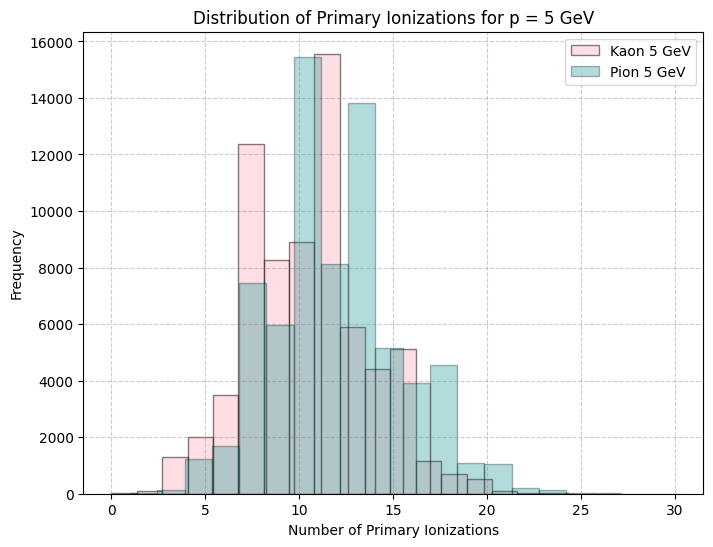

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(np.sum(kaon_momentum_subsets[5.0]['tag_values'] == 1, axis=1), bins=20, edgecolor='black', alpha=0.5, label='Kaon 5 GeV', color = 'pink')
plt.hist(np.sum(pion_momentum_subsets[5.0]['tag_values'] == 1, axis=1)[:70000], bins=20, edgecolor='black', alpha=0.3, label='Pion 5 GeV', color = 'darkcyan')
plt.xlabel('Number of Primary Ionizations')
plt.ylabel('Frequency')
plt.title('Distribution of Primary Ionizations for p = 5 GeV')
plt.legend()
plt.grid(True, color='gray', linestyle='--', alpha=0.4)
plt.savefig(results_dir + 'distrubtion.png')

# FCA, ACA, Ideal, Model

### FCA ACA Ideal

In [11]:
# best for ACA & FCA
T1 = 0.0759587
# T2 = 0.0435265
T2 = 0.0435833

# best for D2 + model - actually not anymore! these values were calculated using a faulty version of D2, scroll down for correct values
# T1 = 0.0411
# T2 = 0.0779

In [12]:
pion_momenta, mean_pion_FCA, std_pion_FCA = process_momentum_subsets_FCA(
    pion_momentum_subsets, "Pion", T1, T2, max_events=50000
)

kaon_momenta, mean_kaon_FCA, std_kaon_FCA = process_momentum_subsets_FCA(
    kaon_momentum_subsets, "Kaon", T1, T2, max_events=50000
)

pion_momenta, mean_pion_ACA, std_pion_ACA = process_momentum_subsets_ACA(
    pion_momentum_subsets, "Pion", T1, T2, max_events=50000
)

kaon_momenta, mean_kaon_ACA, std_kaon_ACA = process_momentum_subsets_ACA(
    kaon_momentum_subsets, "Kaon", T1, T2, max_events=50000
)

Processing Pion momentum 5.0 GeV: 50000 events
  Mean: 13.382, Std: 2.923
Processing Pion momentum 7.5 GeV: 50000 events
  Mean: 13.692, Std: 2.854
Processing Pion momentum 10.0 GeV: 50000 events
  Mean: 14.000, Std: 2.812
Processing Pion momentum 12.5 GeV: 50000 events
  Mean: 14.095, Std: 2.786
Processing Pion momentum 15.0 GeV: 50000 events
  Mean: 14.167, Std: 2.752
Processing Pion momentum 17.5 GeV: 50000 events
  Mean: 14.202, Std: 2.756
Processing Pion momentum 20.0 GeV: 50000 events
  Mean: 14.235, Std: 2.738
Processing Kaon momentum 5.0 GeV: 50000 events
  Mean: 12.435, Std: 3.231
Processing Kaon momentum 7.5 GeV: 50000 events
  Mean: 12.828, Std: 3.141
Processing Kaon momentum 10.0 GeV: 50000 events
  Mean: 13.160, Std: 3.090
Processing Kaon momentum 12.5 GeV: 50000 events
  Mean: 13.315, Std: 3.053
Processing Kaon momentum 15.0 GeV: 50000 events
  Mean: 13.473, Std: 3.008
Processing Kaon momentum 17.5 GeV: 50000 events
  Mean: 13.571, Std: 2.970
Processing Kaon momentum 20.0

In [15]:
print(f"mean_pion_FCA = {mean_pion_FCA}")
print(f"std_pion_FCA = {std_pion_FCA}")
print(f"mean_kaon_FCA = {mean_kaon_FCA}")
print(f"std_kaon_FCA = {std_kaon_FCA}")
print(f"mean_pion_ACA = {mean_pion_ACA}")
print(f"std_pion_ACA = {std_pion_ACA}")
print(f"mean_kaon_ACA = {mean_kaon_ACA}")
print(f"std_kaon_ACA = {std_kaon_ACA}")

mean_pion_FCA = [13.3816491  13.6920924  13.99975965 14.0950521  14.1669504  14.20183935
 14.23479855]
std_pion_FCA = [2.92347539 2.85379083 2.81226118 2.78589349 2.75197088 2.75607408
 2.73786952]
mean_kaon_FCA = [12.43545315 12.82806195 13.1603091  13.3154238  13.473468   13.57145745
 13.6635228 ]
std_kaon_FCA = [3.23143986 3.14091911 3.09016984 3.05348645 3.00829898 2.96961229
 2.91563808]
mean_pion_ACA = [10.61837929 10.9831105  11.39190083 11.48022491 11.56447846 11.60430694
 11.63931755]
std_pion_ACA = [2.79259333 2.7841669  2.803214   2.7971154  2.78057203 2.78289479
 2.76762095]
mean_kaon_ACA = [ 9.73904934 10.13348857 10.5461752  10.70426471 10.85329904 10.94236331
 11.04241907]
std_kaon_ACA = [2.95567114 2.91719632 2.93589847 2.91079657 2.89109936 2.87267928
 2.83672297]


In [14]:
mean_pion, std_pion = process_momentum_subsets_TRUTH(pion_momentum_subsets, 50000)
mean_kaon, std_kaon = process_momentum_subsets_TRUTH(kaon_momentum_subsets, 50000)

### Model

In [17]:
import keras
model = keras.models.load_model(model_dir + 'cnn.keras')

2025-09-26 12:21:46.815476: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 12:21:48.779000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import keras
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)
model = keras.models.load_model(model_dir + 'hls4ml/DNN_8_32_8_v2.h5', custom_objects=co)

OSError: No file or directory found at ../models/hls4ml/DNN_8_32_8_v2.h5

In [ ]:
print(f"mean_pion_model = {mean_pion_model}")
print(f"mean_kaon_model = {mean_kaon_model}")
print(f"std_pion_model = {std_pion_model}")
print(f"std_kaon_model = {std_kaon_model}")

mean_pion_model = [12.179868 12.617454 13.038568 13.190972 13.271128 13.345009 13.391085]
mean_kaon_model = [10.979359  11.425471  11.837021  12.067944  12.2501335 12.406516
 12.537968 ]
std_pion_model = [3.0490048 3.0616848 3.1116018 3.1252563 3.108554  3.1250715 3.1085932]
std_kaon_model = [3.0040374 3.0295682 3.0641053 3.093554  3.088282  3.1090038 3.0915177]


In [ ]:
kp_separation_MODEL

array([0.39666304, 0.39137504, 0.38912037, 0.36117157, 0.32952112,
       0.30108482, 0.2751941 ], dtype=float32)

### D2 + CNN

In [41]:
# T1 = 0.0521
# T2 = 0.0779

T1 = 0.0759587
T2 = 0.0435833

In [42]:
import keras
model = keras.models.load_model(model_dir + 'cnn_peak_0.0759587_0.0435833.keras')

In [43]:
def process_momentum_subsets_D2_MODEL_ONLY_PEAKS(momentum_subsets, model, max_events, T1, T2):
    
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        subset = {d:subset[d][:max_events] for d in subset}

        detected_peaks = numba_batched_derivative_peak_detection(subset['wf_i'], T1, T2)

        peak_data = np.zeros((len(detected_peaks), num_timepoints), dtype=np.float32)
        for i, peaks in enumerate(detected_peaks):
            for peak in peaks:
                peak_data[i, peak] = 1.0

        print(peak_data)
        print(np.max(peak_data))

        # Predict peak counts
        primaries = np.asarray(model.predict(peak_data)).flatten()

        print(primaries)
        
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)

In [44]:
mean_pion_model, std_pion_model = process_momentum_subsets_D2_MODEL_ONLY_PEAKS(pion_momentum_subsets, model, 50000, T1, T2)
mean_kaon_model, std_kaon_model = process_momentum_subsets_D2_MODEL_ONLY_PEAKS(kaon_momentum_subsets, model, 50000, T1, T2)

kp_separation_MODEL = np.abs(mean_pion_model - mean_kaon_model) / ((std_pion_model + std_kaon_model)/2)
kp_separation_MODEL_scaled = kp_separation_MODEL

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1.0
1563/1563 [==============================] - 1s 561us/step
[13.518597 16.563446  8.367571 ... 11.888392 13.770085 13.31988 ]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1.0
1563/1563 [==============================] - 1s 547us/step
[14.704975 13.12514  10.06916  ... 13.221994  8.240805 18.19902 ]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1.0
1563/1563 [==============================] - 1s 528us/step
[10.611068 14.149321 12.875007 ...  9.771982  8.931837 13.362696]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 

In [45]:
print(f"mean_pion_model = {mean_pion_model}")
print(f"mean_kaon_model = {mean_kaon_model}")
print(f"std_pion_model = {std_pion_model}")
print(f"std_kaon_model = {std_kaon_model}")

mean_pion_model = [12.220946 12.574073 12.942758 13.028418 13.108939 13.142925 13.175826]
mean_kaon_model = [11.365388 11.746504 12.118451 12.274979 12.418684 12.508592 12.60298 ]
std_pion_model = [2.5380995 2.5301604 2.540621  2.5245357 2.5044718 2.5053592 2.4960186]
std_kaon_model = [2.7011774 2.675713  2.6883037 2.6744013 2.648245  2.6280668 2.5876966]


In [46]:
kp_separation_MODEL

array([0.32659408, 0.31793666, 0.31528717, 0.28984347, 0.26791894,
       0.24713852, 0.22536525], dtype=float32)

### Residual + Correlation Comparison Plot Between D2 + ACA and DNN 8-32-8

In [11]:
import keras
model = keras.models.load_model(model_dir + 'DNN_8_32_8.keras')

2025-09-26 19:33:41.126600: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 19:33:41.139426: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
ntest = 100000

preds = np.asarray(model.predict(testdata['wf_i']))[:ntest].reshape(ntest)
actual = np.asarray(np.sum(testdata['tag_values'] == 1, axis = 1))[:ntest].reshape(ntest)

3125/3125 [==============================] - 1s 314us/step


In [13]:
# best for ACA & FCA
T1 = 0.0759587
# T2 = 0.0435265
T2 = 0.0435833

region_bounds = {
        'r1': (0, 130),
        'r2': (130, 400),
        'r3': (400, 500)
    }

best_params = {
        'r1': {'b': 4, 'c': 0.9, 'd': 2},
        'r2': {'b': 30, 'c': 1.2999999999999998, 'd': 5},
        'r3': {'b': 91, 'c': 1.7999999999999998, 'd': 2}
    }

b_map = {region: params['b'] for region, params in best_params.items()}
c_map = {region: params['c'] for region, params in best_params.items()}
d_map = {region: params['d'] for region, params in best_params.items()}

detected_peaks = numba_batched_derivative_peak_detection(testdata['wf_i'], T1, T2)
d2_aca_preds = estimate_primary_from_cluster_window_adaptive(
    detected_peaks, b_map, c_map, d_map
        )


In [43]:
len(d2_aca_preds)

100000

In [23]:
residuals

array([-1.000e+00, -1.200e+01, -5.500e+01, -8.300e+01, -1.480e+02,
       -4.140e+02, -5.230e+02, -4.380e+02, -7.000e+01,  5.310e+02,
        1.221e+03,  1.896e+03,  2.567e+03,  2.318e+03,  1.716e+03,
        3.830e+02, -8.980e+02, -1.415e+03, -1.777e+03, -1.632e+03,
       -1.253e+03, -8.540e+02, -4.850e+02, -2.810e+02, -1.600e+02,
       -7.400e+01, -3.200e+01, -2.100e+01, -7.000e+00])

/tmp/ipykernel_1572097/2826381885.py:44: RuntimeWarning: invalid value encountered in divide
  residuals_dnn_error = np.abs(relative_residuals_dnn * np.sqrt(((np.sqrt(pred_counts)) / pred_counts) ** 2 + ((np.sqrt(truth_counts)) / truth_counts) ** 2))
/tmp/ipykernel_1572097/2826381885.py:45: RuntimeWarning: invalid value encountered in divide
  residuals_d2_aca_error = np.abs(relative_residuals_d2_aca * np.sqrt(((np.sqrt(d2_aca_pred_counts)) / d2_aca_pred_counts) ** 2 + ((np.sqrt(truth_counts)) / truth_counts) ** 2))
/tmp/ipykernel_1572097/2826381885.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


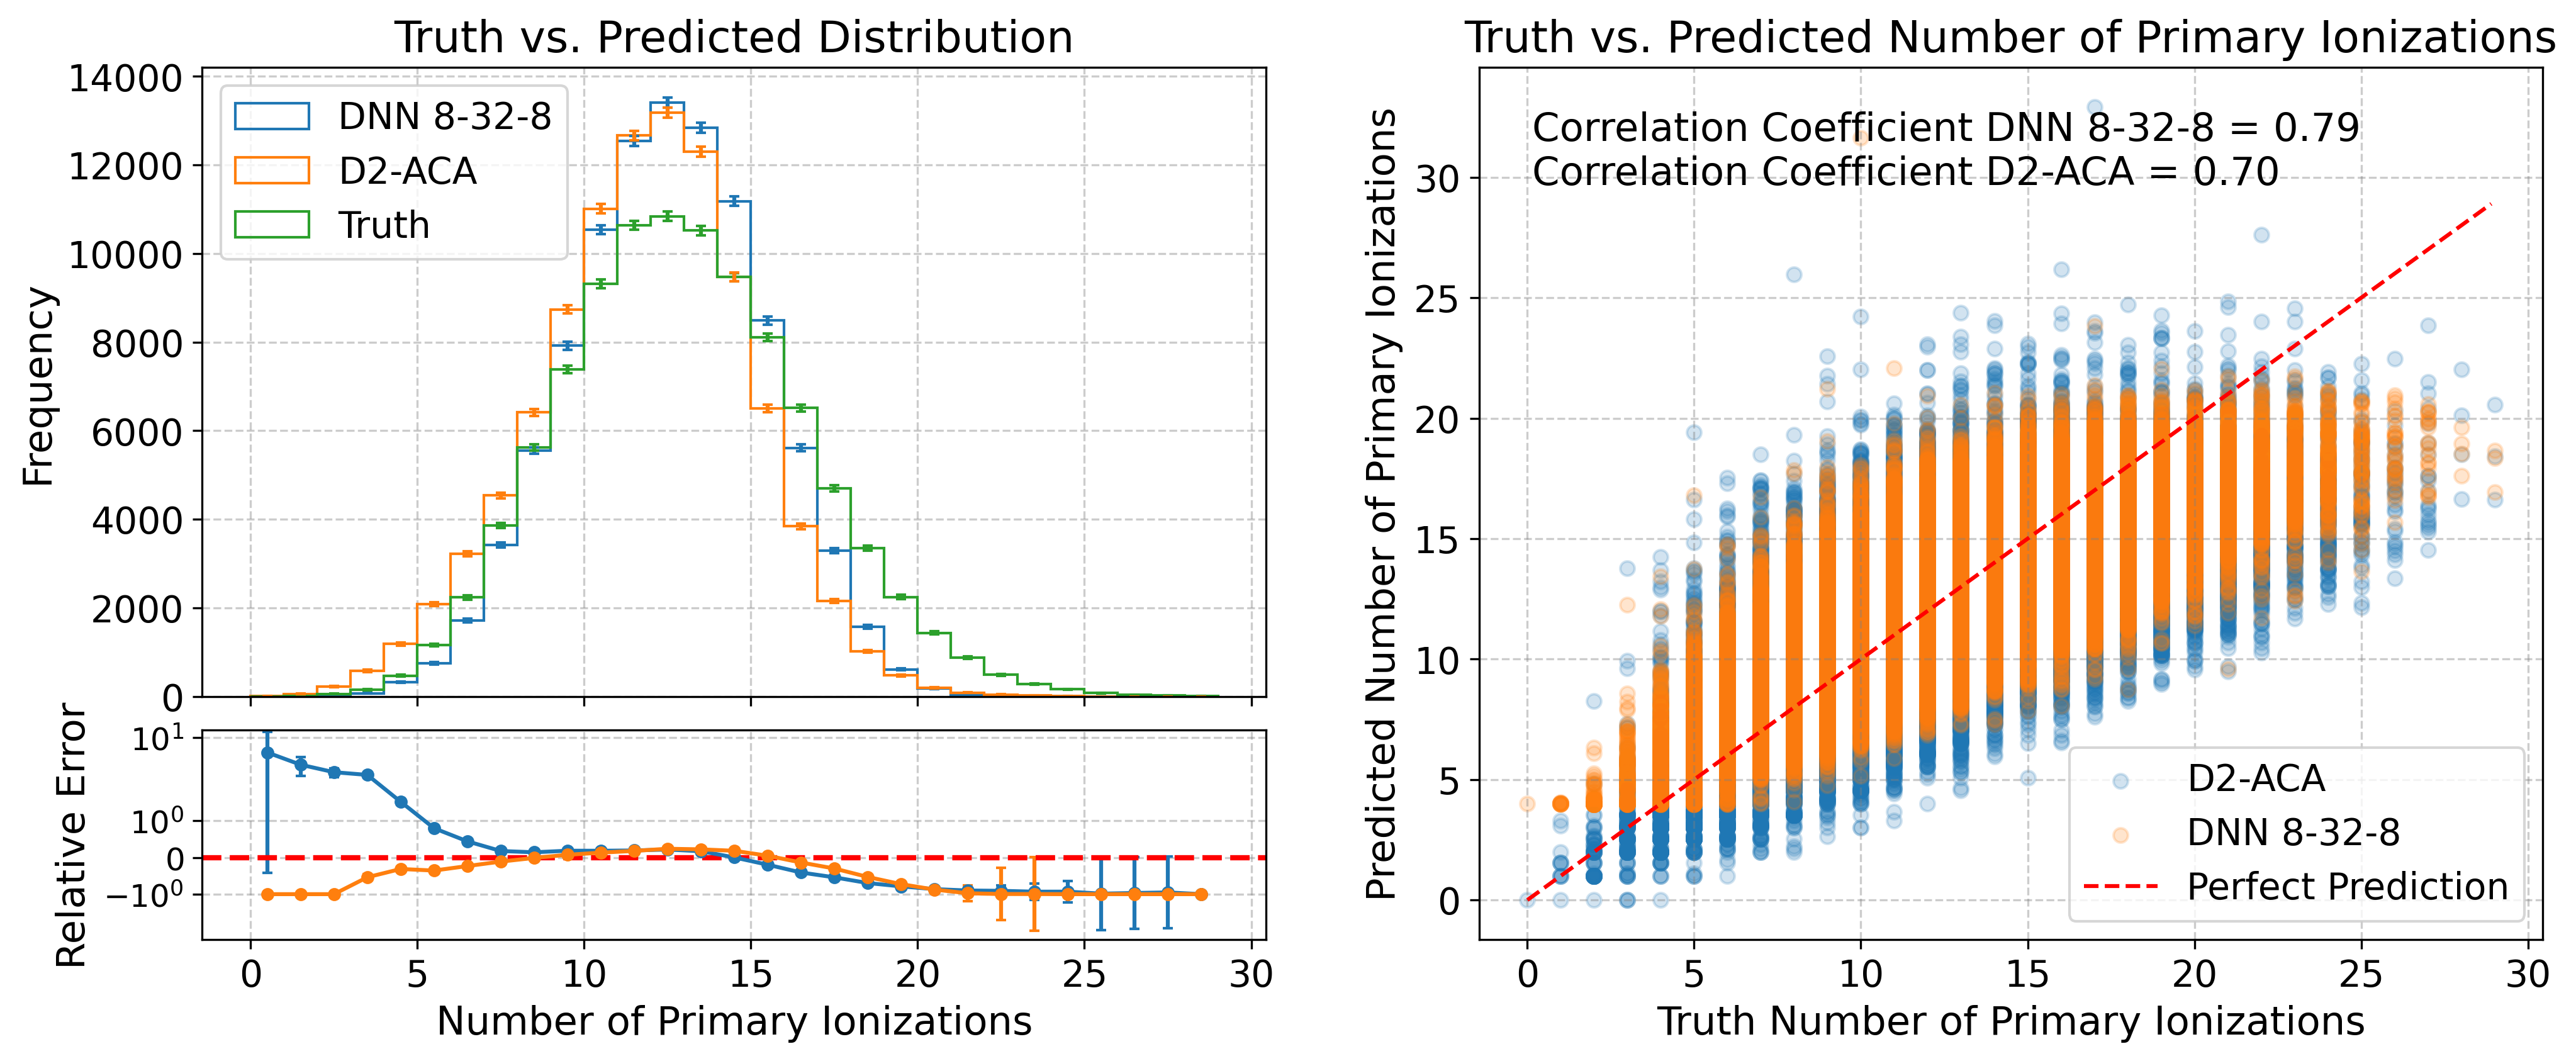

In [29]:
from scipy.stats import pearsonr

fontsize = 15

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,6), dpi=300, 
                        gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.08})

plt.rc('font', size=14)

# Bins for histogram
bins = np.arange(30)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Top left subplot: Histogram comparison
pred_counts, pred_bins, pred_patches = axes[0,0].hist(preds, bins=bins, histtype='step', label='DNN 8-32-8')
d2_aca_pred_counts, pred_bins, pred_d2_aca_patches = axes[0,0].hist(d2_aca_preds, bins=bins, histtype='step', label='D2-ACA')
truth_counts, truth_bins, truth_patches = axes[0,0].hist(actual, bins=bins, histtype='step', label='Truth')

# Add error bars
axes[0,0].errorbar(bin_centers, pred_counts, yerr=np.sqrt(pred_counts), 
                   fmt='none', capsize=2, color=pred_patches[0].get_edgecolor())
axes[0,0].errorbar(bin_centers, truth_counts, yerr=np.sqrt(truth_counts), 
                   fmt='none', capsize=2, color=truth_patches[0].get_edgecolor())
axes[0,0].errorbar(bin_centers, d2_aca_pred_counts, yerr=np.sqrt(d2_aca_pred_counts), 
                   fmt='none', capsize=2, color=pred_d2_aca_patches[0].get_edgecolor())

axes[0,0].legend(loc='upper left')
axes[0,0].set_ylabel("Frequency", fontsize = fontsize)
axes[0,0].set_title('Truth vs. Predicted Distribution')
axes[0,0].grid(True, color='gray', linestyle='--', alpha=0.4)

# Remove x-axis labels for top plot since it shares with bottom
axes[0,0].set_xticklabels([])

# Bottom left subplot: Residual plot (Predicted - Actual)/Actual
# Calculate relative residuals for each bin, avoiding division by zero
relative_residuals_dnn = np.divide(pred_counts - truth_counts, truth_counts, 
                                  out=np.zeros_like(pred_counts, dtype=float), 
                                  where=truth_counts!=0)
relative_residuals_d2_aca = np.divide(d2_aca_pred_counts - truth_counts, truth_counts, 
                                     out=np.zeros_like(d2_aca_pred_counts, dtype=float), 
                                     where=truth_counts!=0)

residuals_dnn_error = np.abs(relative_residuals_dnn * np.sqrt(((np.sqrt(pred_counts)) / pred_counts) ** 2 + ((np.sqrt(truth_counts)) / truth_counts) ** 2))
residuals_d2_aca_error = np.abs(relative_residuals_d2_aca * np.sqrt(((np.sqrt(d2_aca_pred_counts)) / d2_aca_pred_counts) ** 2 + ((np.sqrt(truth_counts)) / truth_counts) ** 2))

nan_mask = np.isnan(residuals_dnn_error)
residuals_dnn_error[nan_mask] = 0

nan_mask = np.isnan(residuals_d2_aca_error)
residuals_d2_aca_error[nan_mask] = 0

axes[1,0].errorbar(bin_centers, relative_residuals_d2_aca, yerr = residuals_d2_aca_error, capsize=2, fmt='-o', markersize=4, alpha=1, label='D2-ACA',
                  color='tab:blue')
axes[1,0].errorbar(bin_centers, relative_residuals_dnn, yerr = residuals_dnn_error, capsize=2, fmt='-o', markersize=4, alpha=1, label='DNN 8-32-8',
                  color='tab:orange')
axes[1,0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axes[1,0].set_xlabel("Number of Primary Ionizations", fontsize = fontsize)
axes[1,0].set_ylabel("Relative Error", fontsize = fontsize)
axes[1,0].grid(True, color='gray', linestyle='--', alpha=0.4)
# axes[1,0].legend(loc='upper right', fontsize=13)
axes[1,0].set_yscale('symlog')
axes[1,0].tick_params(axis='y', labelsize=12) 

# Set same x-limits for both left subplots
x_min, x_max = axes[0,0].get_xlim()
axes[1,0].set_xlim(x_min, x_max)

# Right subplot (spans both rows): Correlation scatter plot
correlation_coefficient, p_value = pearsonr(actual[:10000], preds[:10000])
correlation_coefficient_d2_aca, p_value = pearsonr(actual[:10000], d2_aca_preds[:10000])
x = np.arange(actual.min(), actual.max(), step=0.1)
m = 1
b = 0

# Create a subplot that spans both rows on the right
axes[0,1].remove()  # Remove the top right subplot
axes[1,1].remove()  # Remove the bottom right subplot

# Create a new subplot that spans the right column
ax_corr = plt.subplot2grid((2, 2), (0, 1), rowspan=2)

ax_corr.scatter(actual, d2_aca_preds, s=30, alpha=0.2, label='D2-ACA')
ax_corr.scatter(actual, preds, s=30, alpha=0.2, label='DNN 8-32-8')
ax_corr.plot(x, m*x + b, linestyle='--', color='red', label="Perfect Prediction")
ax_corr.set_xlabel('Truth Number of Primary Ionizations', fontsize=fontsize)
ax_corr.set_ylabel('Predicted Number of Primary Ionizations', fontsize=fontsize)
ax_corr.text(0.05, 0.95, f"Correlation Coefficient DNN 8-32-8 = {correlation_coefficient:.2f}\nCorrelation Coefficient D2-ACA = {correlation_coefficient_d2_aca:.2f}", 
             fontsize=fontsize, color='black', 
             transform=ax_corr.transAxes,
             horizontalalignment='left',    
             verticalalignment='top')
ax_corr.grid(True, color='gray', linestyle='--', alpha=0.4)
ax_corr.set_title('Truth vs. Predicted Number of Primary Ionizations')
ax_corr.legend()

plt.tight_layout()
plt.show()
fig.savefig(results_dir + 'model_performance_revision.png')

In [17]:
residuals_dnn_error

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.73141696e-02,
       2.27007050e-02, 1.67737638e-02, 7.51032750e-03, 2.66533066e-03,
       2.35644611e-04, 1.16325730e-03, 1.86509399e-03, 2.34955312e-03,
       3.05875820e-03, 2.89974802e-03, 2.53268518e-03, 7.33751896e-04,
       2.51325239e-03, 6.84193370e-03, 1.62498296e-02, 3.31657075e-02,
       6.91453082e-02, 2.15521275e-01, 7.05647372e-01, 9.98219099e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

# KP Separation

In [61]:
# len_scaler = np.sqrt(1000/(9*np.sqrt(1)))
len_scaler = 10 * np.sqrt(2)

kp_separation_FCA = np.abs(mean_pion_FCA - mean_kaon_FCA) / ((std_pion_FCA + std_kaon_FCA)/2)
kp_separation_FCA_scaled = kp_separation_FCA * len_scaler

print(f"\nSeparation Power FCA: {kp_separation_FCA}")
print(f"\nSeparation Power FCA scaled: {kp_separation_FCA_scaled}")

kp_separation_ACA = np.abs(mean_pion_ACA - mean_kaon_ACA) / ((std_pion_ACA + std_kaon_ACA)/2)
kp_separation_ACA_scaled = kp_separation_ACA * len_scaler

print(f"\nSeparation Power ACA: {kp_separation_ACA}")
print(f"\nSeparation Power ACA scaled: {kp_separation_ACA_scaled}")

kp_separation_TRUTH = np.abs(mean_pion - mean_kaon) / ((std_pion + std_kaon)/2)
kp_separation_TRUTH_scaled = kp_separation_TRUTH * len_scaler

print(f"\nSeparation Power TRUTH: {kp_separation_TRUTH}")
print(f"\nSeparation Power TRUTH scaled: {kp_separation_TRUTH_scaled}")

kp_separation_MODEL = np.abs(mean_pion_model - mean_kaon_model) / ((std_pion_model + std_kaon_model)/2)
kp_separation_MODEL_scaled = kp_separation_MODEL * len_scaler

print(f"\nSeparation Power MODEL: {kp_separation_MODEL}")
print(f"\nSeparation Power MODEL scaled: {kp_separation_MODEL_scaled}")




Separation Power FCA: [0.30746027 0.28826431 0.28444231 0.26702434 0.24078122 0.22019435
 0.20209604]

Separation Power FCA scaled: [4.34814483 4.07667291 4.02262169 3.77629449 3.40516066 3.11401839
 2.85806961]

Separation Power ACA: [0.30594624 0.29804168 0.29472349 0.27188934 0.25078301 0.23408539
 0.21301279]

Separation Power ACA scaled: [4.32673322 4.21494583 4.16801958 3.84509588 3.54660738 3.31046733
 3.01245583]

Separation Power TRUTH: [0.46805582 0.45660283 0.45609252 0.42223516 0.38629371 0.34968447
 0.3134905 ]

Separation Power TRUTH scaled: [6.61930893 6.4573392  6.45012221 5.97130695 5.46301805 4.94528514
 4.43342522]

Separation Power MODEL: [0.34784585 0.33151114 0.34116796 0.3138123  0.28217134 0.2595276
 0.24201353]

Separation Power MODEL scaled: [4.9192834 4.6882753 4.8248434 4.437976  3.9905055 3.6702745 3.422588 ]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Plot

### Truncated

In [54]:
import numpy as np

kp_10_5_0_6_pruned_hls = [0.34429792, 0.3276877 , 0.33450112, 0.31061912, 0.27586433, 0.2588253 , 0.239413  ]
kp_10_5_hls = [0.34691727, 0.3330357 , 0.34003016, 0.31206596, 0.27897048,0.26003128, 0.24141768]
kp_separation_DNN = [0.34784585, 0.33151114, 0.34116796, 0.3138123, 0.28217134, 0.2595276, 0.24201353]

kp_separation_FCA = [0.30746027, 0.28826431, 0.28444231, 0.26702434, 0.24078122, 0.22019435, 0.20209604]
kp_separation_ACA = [0.30594624, 0.29804168, 0.29472349, 0.27188934, 0.25078301, 0.23408539, 0.21301279]
kp_separation_TRUTH = [0.46805582, 0.45660283, 0.45609252, 0.42223516, 0.38629371, 0.34968446, 0.3134905]

kp_separation_DNN = np.asarray(kp_separation_DNN)
kp_10_5_0_6_pruned_hls = np.asarray(kp_10_5_0_6_pruned_hls)
kp_10_5_hls = np.asarray(kp_10_5_hls)

kp_separation_FCA = np.asarray(kp_separation_FCA)
kp_separation_ACA = np.asarray(kp_separation_ACA)
kp_separation_TRUTH = np.asarray(kp_separation_TRUTH)

momenta = [5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]


In [55]:
mean_pion_FCA = np.asarray([13.3816491,  13.6920924,  13.99975965, 14.0950521,  14.1669504,  14.20183935, 14.23479855])
std_pion_FCA = np.asarray([2.92347539, 2.85379083, 2.81226118, 2.78589349, 2.75197088, 2.75607408, 2.73786952])
mean_kaon_FCA = np.asarray([12.43545315, 12.82806195, 13.1603091,  13.3154238,  13.473468,   13.57145745, 13.6635228])
std_kaon_FCA = np.asarray([3.23143986, 3.14091911, 3.09016984, 3.05348645, 3.00829898, 2.96961229, 2.91563808])

mean_pion_ACA = np.asarray([10.61837929, 10.9831105,  11.39190083, 11.48022491, 11.56447846, 11.60430694, 11.63931755])
std_pion_ACA = np.asarray([2.79259333, 2.7841669,  2.803214,   2.7971154,  2.78057203, 2.78289479, 2.76762095])
mean_kaon_ACA = np.asarray([ 9.73904934, 10.13348857, 10.5461752,  10.70426471, 10.85329904, 10.94236331, 11.04241907])
std_kaon_ACA = np.asarray([2.95567114, 2.91719632, 2.93589847, 2.91079657, 2.89109936, 2.87267928, 2.83672297])

mean_pion = np.asarray([12.05146, 12.55666, 12.99352, 13.17736, 13.2958,  13.38972, 13.42894])
mean_kaon = np.asarray([10.49956, 11.01324, 11.43036, 11.71026, 11.94738, 12.15828, 12.3257])
std_pion = np.asarray([3.43191665, 3.48601056, 3.54225324, 3.57869018, 3.58137716, 3.60991389, 3.59298072])
std_kaon = np.asarray([3.19934365, 3.27443807, 3.31232098, 3.37051787, 3.39994281, 3.4332357, 3.4454462])

In [56]:
mean_pion_DNN_8_32_8 = np.asarray([12.248274, 12.6138115, 12.953749, 13.062025, 13.120034, 13.180326, 13.224061])
mean_kaon_DNN_8_32_8 = np.asarray([11.293346, 11.703152, 12.013791, 12.196028, 12.343661, 12.466275, 12.56335])
std_pion_DNN_8_32_8 = np.asarray([2.7342951, 2.7324836, 2.74423, 2.7446942, 2.7322724, 2.7368987, 2.713359])
std_kaon_DNN_8_32_8 = np.asarray([2.7562258, 2.7615082, 2.766004, 2.774512, 2.7705755, 2.765801, 2.7467597])

mean_pion_10_5 = np.asarray([12.2719,   12.641725, 12.982666, 13.094157, 13.14487,  13.209694, 13.254355])
mean_kaon_10_5 = np.asarray([11.328878, 11.732537, 12.049853, 12.234825, 12.38008,  12.497139, 12.597904])
std_pion_10_5 = np.asarray([2.714778,  2.7236295, 2.7381556, 2.7383568, 2.720792,  2.7285757, 2.7012699])
std_kaon_10_5 = np.asarray([2.7218022, 2.7363694, 2.7484913, 2.7690182, 2.7621508, 2.751957,  2.7370334])

mean_pion_10_5_0_6_pruned = np.asarray([12.346405, 12.715913, 13.062882, 13.178156, 13.228654, 13.294591, 13.336811])
mean_kaon_10_5_0_6_pruned = np.asarray([11.399652, 11.811978, 12.13692,  12.31504,  12.463637, 12.579031, 12.678208])
std_pion_10_5_0_6_pruned = np.asarray([2.755281,  2.7584703, 2.7689126, 2.770166,  2.7644668, 2.7612262, 2.7342384])
std_kaon_10_5_0_6_pruned = np.asarray([2.744337,  2.758578,  2.7674665, 2.7872274, 2.7818577, 2.7680628, 2.767574])


In [57]:
# old t1 and t2 values d2 peak cnn

kp_separation_D2_CNN = np.asarray([0.35967165, 0.34728777, 0.3533162 , 0.3255067 , 0.2949236 ,
       0.27219197, 0.25244477])

mean_pion_d2_cnn = np.asarray([12.193845, 12.553762, 12.873565, 12.991362, 13.052334, 13.126576, 13.156685])
mean_kaon_d2_cnn = np.asarray([11.184347, 11.573255, 11.872295, 12.062966, 12.213483, 12.350093, 12.439443])
std_pion_d2_cnn = np.asarray([2.8175051, 2.8314152, 2.849387, 2.8606484, 2.8501105, 2.8615623, 2.85083])
std_kaon_d2_cnn = np.asarray([2.795935, 2.8152442, 2.8184505, 2.8436599, 2.8384883, 2.8438487, 2.8315392])

In [58]:
# new t1 and t2 values d2 peak cnn

kp_separation_D2_CNN = np.asarray([0.32659408, 0.31793666, 0.31528717, 0.28984347, 0.26791894,
       0.24713852, 0.22536525])

mean_pion_d2_cnn = np.asarray([12.220946, 12.574073, 12.942758, 13.028418, 13.108939, 13.142925, 13.175826])
mean_kaon_d2_cnn = np.asarray([11.365388, 11.746504, 12.118451, 12.274979, 12.418684, 12.508592, 12.60298])
std_pion_d2_cnn = np.asarray([2.5380995, 2.5301604, 2.540621, 2.5245357, 2.5044718, 2.5053592, 2.4960186])
std_kaon_d2_cnn = np.asarray([2.7011774, 2.675713, 2.6883037, 2.6744013, 2.648245, 2.6280668, 2.5876966])

In [59]:
mean_pion_cnn = np.asarray([12.179868, 12.617454, 13.038568, 13.190972, 13.271128, 13.345009, 13.391085])
mean_kaon_cnn = np.asarray([10.979359, 11.425471, 11.837021, 12.067944, 12.2501335, 12.406516, 12.537968])
std_pion_cnn = np.asarray([3.0490048, 3.0616848, 3.1116018, 3.1252563, 3.108554, 3.1250715, 3.1085932])
std_kaon_cnn = np.asarray([3.0040374, 3.0295682, 3.0641053, 3.093554, 3.088282, 3.1090038, 3.0915177])

kp_separation_cnn = np.asarray([0.39666304, 0.39137504, 0.38912037, 0.36117157, 0.32952112,
       0.30108482, 0.2751941])

In [62]:
# kaon pion error
import math

len_scaler = 10 * math.sqrt(2)
import math

import numpy as np

def calculate_separation_error(mean_pion, mean_kaon, std_pion, std_kaon, n_events=50000):
    mean_pion_error = std_pion / np.sqrt(n_events)
    mean_kaon_error = std_kaon / np.sqrt(n_events)
    std_pion_error = std_pion / np.sqrt(2 * n_events)
    std_kaon_error = std_kaon / np.sqrt(2 * n_events)

    x = mean_pion
    y = mean_kaon
    z = std_pion
    t = std_kaon
    a = mean_pion_error
    b = mean_kaon_error
    c = std_pion_error
    d = std_kaon_error

    numerator = (a**2 + b**2) * (t + z)**2 + (c**2 + d**2) * (x - y)**2
    denominator = (t + z)**4
    result = 2 * np.sqrt(numerator / denominator)
    return result

y_err_truth = calculate_separation_error(mean_pion, mean_kaon, std_pion, std_kaon) * len_scaler
y_err_fca = calculate_separation_error(mean_pion_FCA, mean_kaon_FCA, std_pion_FCA, std_kaon_FCA)* len_scaler
y_err_aca = calculate_separation_error(mean_pion_ACA, mean_kaon_ACA, std_pion_ACA, std_kaon_ACA)* len_scaler
y_err_dnn_8_32_8 = calculate_separation_error(mean_pion_DNN_8_32_8, mean_kaon_DNN_8_32_8, std_pion_DNN_8_32_8, std_kaon_DNN_8_32_8)* len_scaler
y_err_10_5 = calculate_separation_error(mean_pion_10_5, mean_kaon_10_5, std_pion_10_5, std_kaon_10_5)* len_scaler
y_err_10_5_0_6_pruned = calculate_separation_error(mean_pion_10_5_0_6_pruned, mean_kaon_10_5_0_6_pruned, std_pion_10_5_0_6_pruned, std_kaon_10_5_0_6_pruned)* len_scaler
y_err_d2_cnn = calculate_separation_error(mean_pion_d2_cnn, mean_kaon_d2_cnn, std_pion_d2_cnn, std_kaon_d2_cnn)* len_scaler
y_err_cnn = calculate_separation_error(mean_pion_cnn, mean_kaon_cnn, std_pion_cnn, std_kaon_cnn)* len_scaler




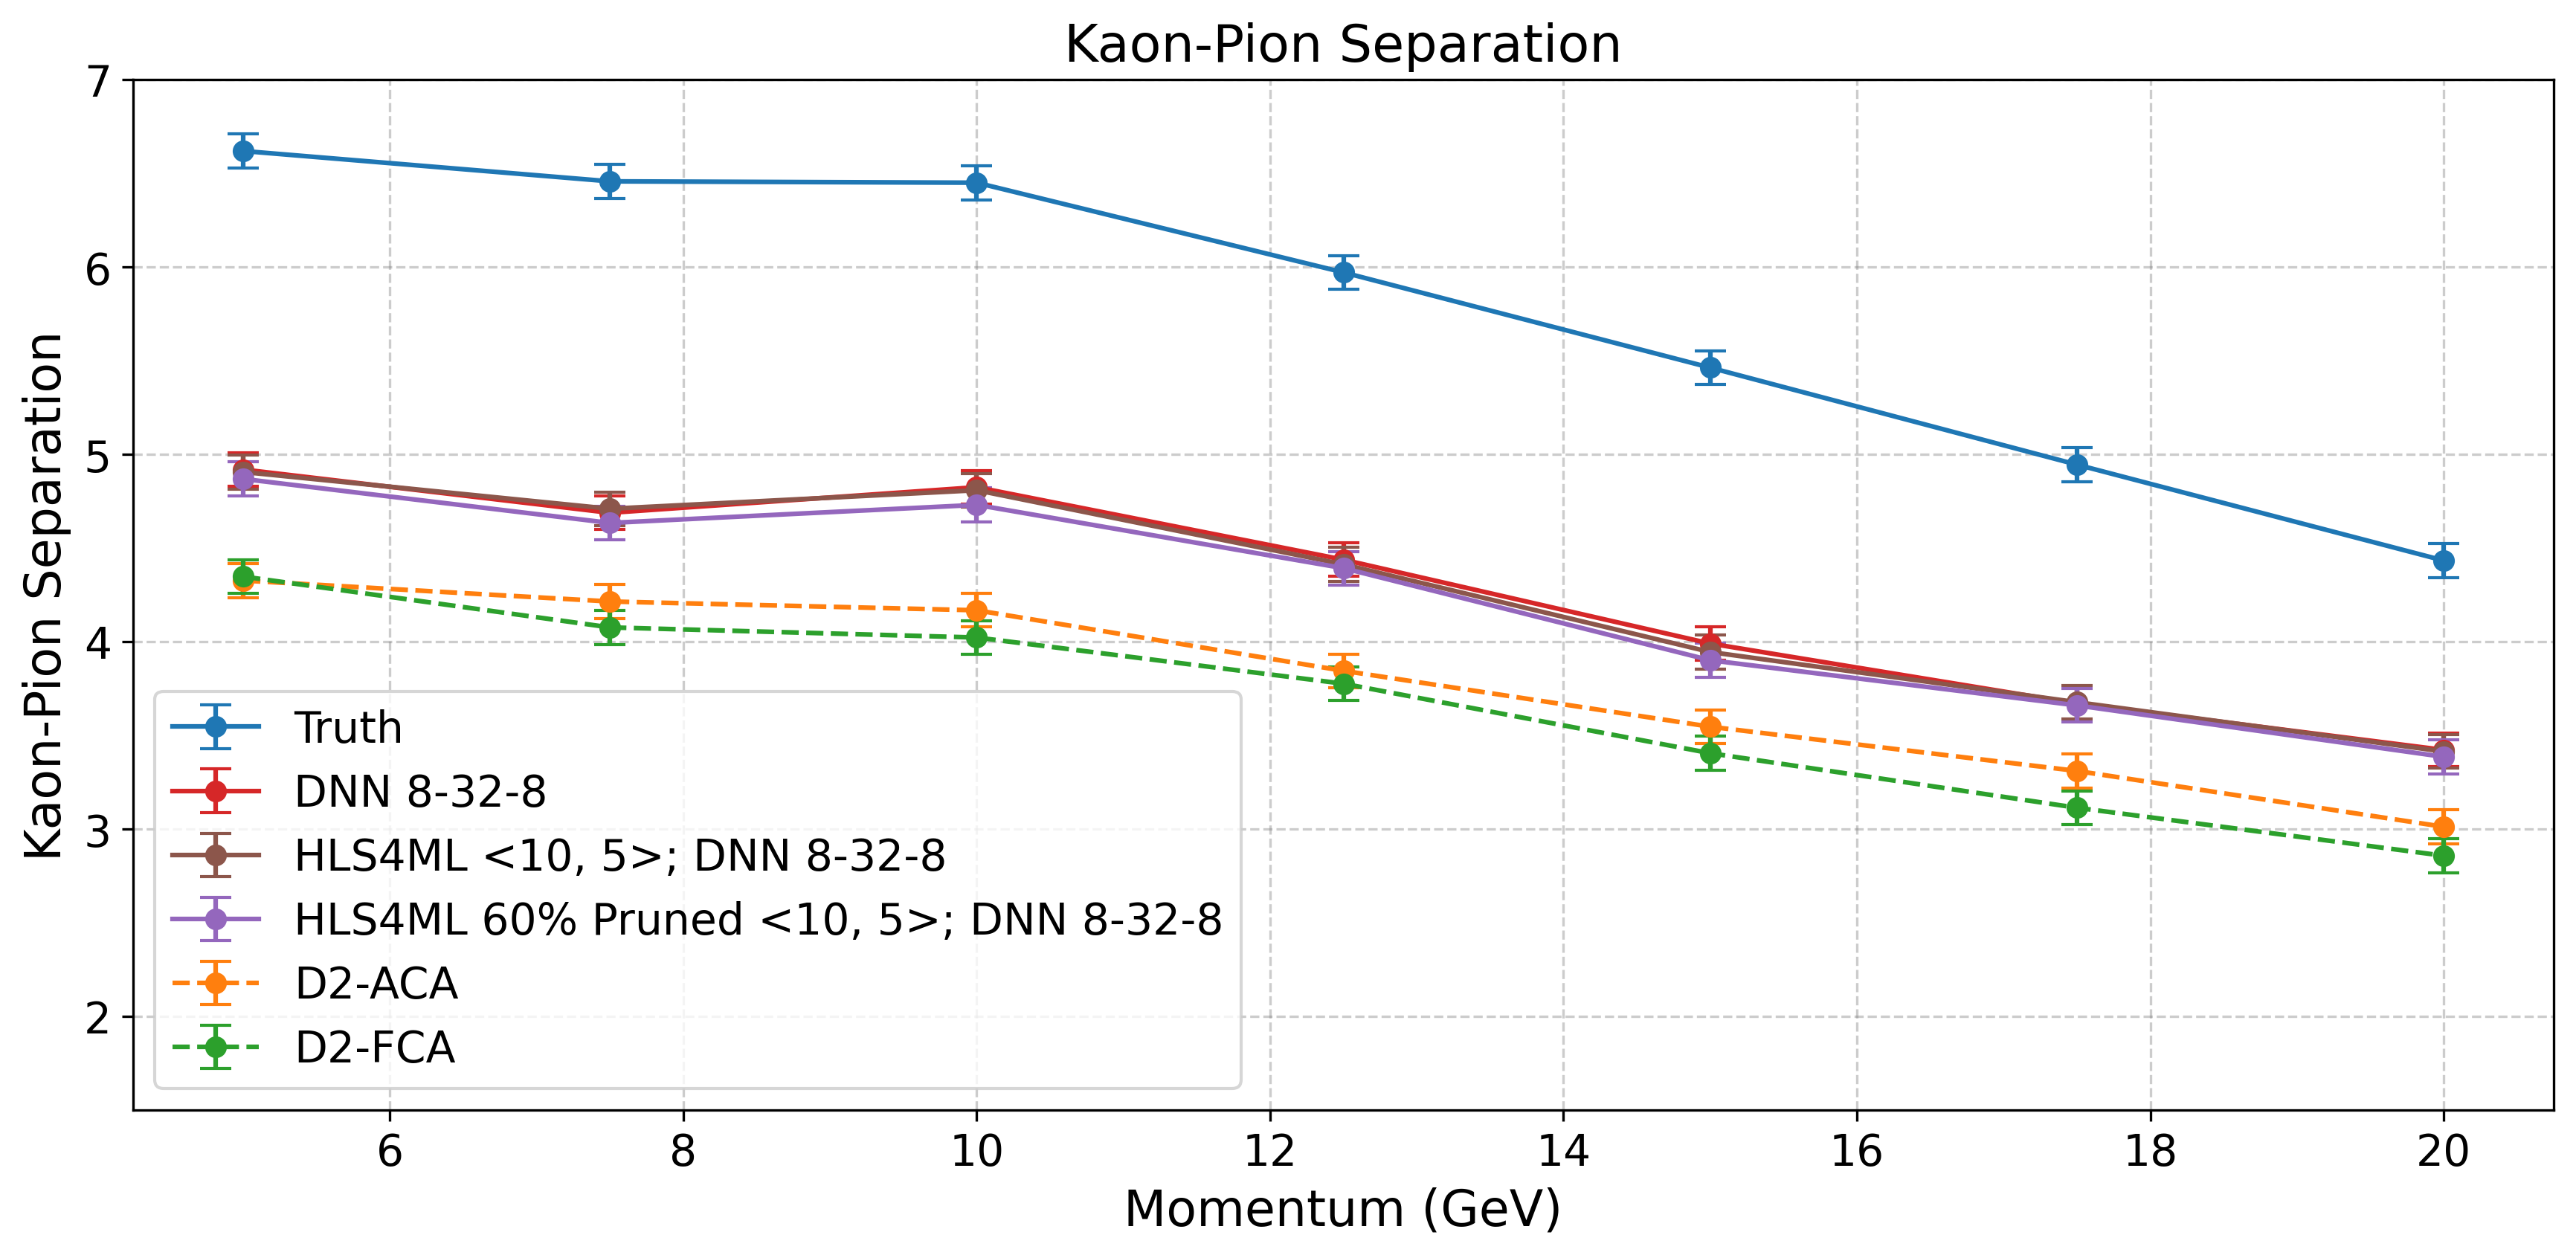

In [84]:
import matplotlib.pyplot as plt
results_dir = '../results/'
import math

fontsize = 16

plt.rc('font', size=14)

len_scaler = 10 * math.sqrt(2)

plt.figure(figsize=(14, 6), dpi=300)
plt.errorbar(momenta, kp_separation_TRUTH * len_scaler, yerr = y_err_truth, fmt='-o', label = 'Truth', capsize=5)

plt.errorbar(momenta, np.asarray(kp_separation_DNN) * len_scaler, yerr = y_err_dnn_8_32_8, fmt='-o', label = 'DNN 8-32-8', capsize=5, color = 'tab:red')

plt.errorbar(momenta, np.asarray(kp_10_5_hls) * len_scaler, yerr = y_err_10_5, fmt='-o', label = 'HLS4ML <10, 5>; DNN 8-32-8',capsize=5, color = 'tab:brown')
plt.errorbar(momenta, np.asarray(kp_10_5_0_6_pruned_hls) * len_scaler, yerr = y_err_10_5_0_6_pruned, fmt='-o', label = 'HLS4ML 60% Pruned <10, 5>; DNN 8-32-8',capsize=5, color = 'tab:purple')

plt.errorbar(momenta, kp_separation_ACA * len_scaler, yerr = y_err_aca, fmt='--o', label = 'D2-ACA', capsize=5, color ='tab:orange')
plt.errorbar(momenta, kp_separation_FCA * len_scaler, yerr = y_err_fca, fmt='--o', label = 'D2-FCA', capsize=5, color = 'tab:green')

# plt.errorbar(momenta, kp_separation_D2_CNN * len_scaler, yerr = y_err_d2_cnn, fmt='-o', label = 'D2-CNN', capsize=5)    
# plt.errorbar(momenta, kp_separation_cnn * len_scaler, yerr = y_err_cnn, fmt='-o', label = 'CNN', capsize=5)

plt.ylim(1.5, 7)
plt.grid(True, color='gray', linestyle='--', alpha=0.4)
plt.xlabel('Momentum (GeV)', fontsize = fontsize)
plt.ylabel('Kaon-Pion Separation', fontsize = fontsize)
plt.legend()
plt.title('Kaon-Pion Separation')
plt.savefig(results_dir + 'kaon_pion_50k_revision.png')